# 数据背景

**涉及技术**

A/B 测试在网站优化中起着至关重要的作用。分析 A/B 测试数据是数据科学家的重要职责，尤其是要确保结果可靠可信，并能够得出结论。此外，公司通常会同时运行几十个，甚至数百个 A/B 测试。手动分析所有测试将耗费大量时间和人力。因此，常见的做法是查看典型的 A/B 测试分析步骤，并尽可能地自动化这些步骤，从而为数据科学家腾出时间去处理更高级别的课题。

**问题背景**

XYZ 公司是一家全球性电子商务网站，拥有多个本地化版本。XYZ 的一位数据科学家注意到，西班牙用户的转化率明显高于其他西班牙语国家的用户。因此，她与负责西班牙和拉丁美洲的国际团队进行了讨论，以了解可能的原因。西班牙和拉丁美洲的国家经理提出，原因可能是翻译问题。所有西班牙语国家使用的都是由西班牙人编写的相同翻译。他们决定尝试一个测试，让每个国家都使用当地人编写的翻译。例如，阿根廷用户将看到由阿根廷人编写的翻译，墨西哥用户看到由墨西哥人编写的翻译，以此类推。显然，西班牙的用户不会有任何变化。

然而，测试结束后，他们非常惊讶，因为测试结果是负面的。也就是说，非本地化的翻译表现得更好！

**任务**

确认测试结果确实是负面的，也就是说，只有一个翻译版本（适用于西班牙和拉丁美洲）的旧版本表现得更好。

解释可能的原因。是否确实是本地化的翻译效果较差？

如果找到了问题所在，设计一个算法，在未来发生同样的问题时返回 FALSE，如果一切正常且结果可信，则返回 TRUE。

**数据集信息**

test_table (测试结果的通用信息)：

| 列名 | 描述 | 可能的值 |
|------|------|----------|
| user_id | 用户的唯一标识 | 可与其他表连接 |
| date | 用户首次访问网站的日期 | 日期格式 |
| source | 营销渠道 | Ads, SEO, Direct |
| device | 用户使用的设备 | mobile, web |
| browser_language | 用户选择的语言 | EN, ES, Other |
| ads_channel | 广告显示的网站 | Google, Facebook, Bing, Yahoo, Other, NA |
| browser | 用户使用的浏览器 | IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera |
| conversion | 用户是否转化 | 1 (转化), 0 (未转化) |
| test | 用户所属组别 | 1 (测试组), 0 (对照组) |

user_table (用户信息)：

| 列名 | 描述 | 可能的值 |
|------|------|----------|
| user_id | 用户的唯一标识 | 可与其他表连接 |
| sex | 用户性别 | Male, Female |
| age | 用户年龄 | 数字 |
| country | 用户所在国家 | 国家名称 |

# 导入必备的库

常用的数据分析库：

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

%matplotlib inline

# 导入数据集

首先从父目录的子目录中导入两个数据集：

In [53]:
# 导入测试数据集
test_table = pd.read_csv('./../dataset/02. Translation_Test/test_table.csv')
# 导入用户数据集
user_table = pd.read_csv('./../dataset/02. Translation_Test/user_table.csv')

然后分别查看一下前几行：

In [54]:
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [55]:
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


# 缺失值处理

查看一下两个列表中存在着多少相同的user_id和不同的user_id：

In [56]:
# 提取两个表的 user_id 列
user_ids_user_table = set(user_table['user_id'])
user_ids_test_table = set(test_table['user_id'])

# 计算同时存在于两个表中的 user_id
common_user_ids = user_ids_user_table.intersection(user_ids_test_table)
count_common = len(common_user_ids)

# 计算只存在于其中一个表中的 user_id
unique_user_ids = user_ids_user_table.symmetric_difference(user_ids_test_table)
count_unique = len(unique_user_ids)

print(f"同时存在于两个表中的 user_id 数量: {count_common}")
print(f"仅存在于其中一个表中的 user_id 数量: {count_unique}")

同时存在于两个表中的 user_id 数量: 452867
仅存在于其中一个表中的 user_id 数量: 454


或者可以这么写：

In [57]:
# 检查test_table中有多少user_id不在user_table中
test_not_in_user = test_table[~test_table['user_id'].isin(user_table['user_id'])]

# 检查user_table中有多少user_id不在test_table中
user_not_in_test = user_table[~user_table['user_id'].isin(test_table['user_id'])]

In [58]:
print(f"test_table中不在user_table的用户数: {len(test_not_in_user)}")
print(f"user_table中不在test_table的用户数: {len(user_not_in_test)}")

# 计算比例
print(f"test_table中不匹配的比例: {len(test_not_in_user) / len(test_table):.2%}")
print(f"user_table中不匹配的比例: {len(user_not_in_test) / len(user_table):.2%}")

test_table中不在user_table的用户数: 454
user_table中不在test_table的用户数: 0
test_table中不匹配的比例: 0.10%
user_table中不匹配的比例: 0.00%


可以认为user_table是test_table的一个子集，而test_table中存在着大概0.10%的比例的用户不在user_table中，对于这些数据，我们采用删除处理。

In [59]:
test_table_cleaned = test_table[test_table['user_id'].isin(user_table['user_id'])]

完成删除之后进行验证：

In [60]:
print(f"原始test_table行数: {len(test_table)}")
print(f"清理后test_table行数: {len(test_table_cleaned)}")
print(f"删除的行数: {len(test_table) - len(test_table_cleaned)}")

原始test_table行数: 453321
清理后test_table行数: 452867
删除的行数: 454


In [61]:
# 确保删除的行数与之前发现的不匹配数量相同
assert len(test_table) - len(test_table_cleaned) == 454, "删除的行数应该是454"

可以发现这些数据已经被删除了。

然后开始进行合并：

In [62]:
# 合并清理后的数据
df_clean = pd.merge(test_table_cleaned, user_table, on='user_id')

验证一下：

In [63]:
# 验证合并后的数据集
print(f"合并后的数据集行数: {len(df_clean)}")
print(f"合并后的数据集中unique user_id的数量: {df_clean['user_id'].nunique()}")

# 确保合并后的数据集中用户数量与user_table相同
assert len(df_clean) == len(user_table), "合并后的数据集行数应该与user_table相同"

合并后的数据集行数: 452867
合并后的数据集中unique user_id的数量: 452867


现在已经够完成了数据集的合并，然后开始检查缺失值：

In [64]:
# 基本的数据检查
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           452867 non-null  int64 
 1   date              452867 non-null  object
 2   source            452867 non-null  object
 3   device            452867 non-null  object
 4   browser_language  452867 non-null  object
 5   ads_channel       181693 non-null  object
 6   browser           452867 non-null  object
 7   conversion        452867 non-null  int64 
 8   test              452867 non-null  int64 
 9   sex               452867 non-null  object
 10  age               452867 non-null  int64 
 11  country           452867 non-null  object
dtypes: int64(4), object(8)
memory usage: 41.5+ MB
None


In [65]:
print(df_clean.isnull().sum())

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271174
browser                  0
conversion               0
test                     0
sex                      0
age                      0
country                  0
dtype: int64


从缺失值的情况可以发现，ads_channel中存在着大量的缺失值，占比为：

In [66]:
print(round(271174 / 452867 * 100, 2), " % 缺失值")

59.88  % 缺失值


对于缺失值，我们可以采取的措施为：

- 填充缺失值
- 删除缺失值所在的行（如果占比小）
- 删除缺失值坐在的列（如果占比大）
- 将缺失值视作是有意义的数据来进行分析

在这个数据集中，ds_channel 表示广告渠道，只有在 source 为 'Ads' 时才有值，其他情况（如 SEO 或 Direct）下为 NA。这解释了为什么有这么多缺失值。

In [67]:
print(df_clean.groupby('source')['ads_channel'].apply(lambda x: x.isnull().sum()))

source
Ads            0
Direct     90738
SEO       180436
Name: ads_channel, dtype: int64


分析一下这个结果：

- Ads 来源的 ads_channel 全部都有值（0个缺失）。
- Direct 来源有 90,738 个 ads_channel 为空。
- SEO 来源有 180,436 个 ads_channel 为空。

这个结果完全符合我们的预期，因为 ads_channel 只对广告（Ads）流量有意义。对于 Direct 和 SEO 流量，ads_channel 自然是不适用的。

基于这个信息，采取以下策略：

- 保留 ads_channel 列，因为它对于 Ads 流量的分析非常有价值。
- 对于 Direct 和 SEO 流量，我们可以将 ads_channel 的空值填充为 "Not Applicable"。

In [68]:
df_clean.loc[df_clean['source'].isin(['Direct', 'SEO']), 'ads_channel'] = 'Not Applicable'

In [69]:
print(df_clean.groupby('source')['ads_channel'].value_counts(dropna=False))

source  ads_channel   
Ads     Facebook           68358
        Google             68113
        Yahoo              27409
        Bing               13670
        Other               4143
Direct  Not Applicable     90738
SEO     Not Applicable    180436
Name: count, dtype: int64


这个数据分布给了我们很多有价值的洞察。让我们来分析一下这个结果：

1. 广告（Ads）来源细分：
   - Facebook: 68,358
   - Google: 68,113
   - Yahoo: 27,409
   - Bing: 13,670
   - Other: 4,143
   - 总广告流量：181,693
2. 直接（Direct）流量：90,738
3. 搜索引擎优化（SEO）流量：180,436
4. 总样本量：452,867

基于这些数据，我们可以得出以下几点观察和建议：

1. 数据分布：
   - 广告流量占总流量的 40.12%
   - SEO 流量占 39.84%
   - 直接流量占 20.04%
2. 广告渠道分析：
   - Facebook 和 Google 是主要的广告渠道，几乎贡献了相等的流量。
   - Yahoo 和 Bing 贡献了较少但仍然显著的流量。
   - "Other" 渠道的流量相对较小。


基于这些观察，以下是一些思路：

1. 整体 A/B 测试：继续进行整体的 A/B 测试，因为样本量足够大，能够得到统计上显著的结果。
2. 分层分析：对不同的流量来源进行分层分析，看看 A/B 测试的效果是否在不同来源间有差异。
3. 广告渠道效果分析：特别关注 Facebook 和 Google 这两个主要渠道的效果对比。

# A/B test 分析

对于大样本的A/B测试，特别是处理二元结果（如转化与否）时，使用比例检验更为合适。这种方法直接比较两个比例，而不是比较均值。它还可以提供置信区间，有助于评估结果的精确度。

In [70]:
# # 首先是 A/B test函数

def ab_test(group):
    control = group[group['test'] == 0]['conversion']
    treatment = group[group['test'] == 1]['conversion']
    _, p_value = stats.ttest_ind(control, treatment)
    lift = treatment.mean() - control.mean()
    return pd.Series({
        'control_conv_rate': control.mean(),
        'treatment_conv_rate': treatment.mean(),
        'lift': lift,
        'relative_lift': lift / control.mean(),
        'p_value': p_value,
        'sample_size': len(group)
    })

然后进行整体的A/B test：

In [71]:
# 整体 A/B 测试
overall_result = ab_test(df_clean)
print("整体 A/B 测试结果:")
print(overall_result)

整体 A/B 测试结果:
control_conv_rate      5.515557e-02
treatment_conv_rate    4.341116e-02
lift                  -1.174441e-02
relative_lift         -2.129324e-01
p_value                6.085918e-74
sample_size            4.528670e+05
dtype: float64


这个A/B测试的结果揭示了一个有趣且出乎意料的情况。控制组的转化率约为5.52%，而处理组（即接受新变化的组）的转化率约为4.34%。这表明处理组的表现实际上低于控制组，差距相当显著。具体来说，我们观察到处理组的转化率比控制组低了约1.17个百分点，这相当于相对于控制组下降了21.29%。

从统计学的角度来看，这个结果是高度显著的。P值极低（6.09e-74），远远小于通常用作显著性标准的0.05或0能0.01。这意味着我们观察到的差异几乎不可能是由随机变化造成的，而是很可能反映了处理（即我们在测试中引入的变化）的真实效果。

样本量相当大，超过45万个数据点，这进一步增强了我们对结果可靠性的信心。如此大的样本量使得即使相对较小的效应也能被准确检测到。

然而，这个结果可能令人感到意外或失望，因为通常我们期望处理组（即新的变化）能够提高转化率。在这种情况下，新的变化似乎产生了负面影响。这提醒我们，并非所有的改变都会带来积极的结果，有时我们认为会改善用户体验或提高转化率的改变实际上可能会产生相反的效果。

接着是分层A/B测试：

In [72]:
# 按来源分层的 A/B 测试
source_results = df_clean.groupby('source').apply(ab_test)

print("\n按来源分层的 A/B 测试结果:")
print(source_results)


按来源分层的 A/B 测试结果:
        control_conv_rate  treatment_conv_rate      lift  relative_lift  \
source                                                                    
Ads              0.055436             0.043529 -0.011907      -0.214787   
Direct           0.056195             0.042512 -0.013683      -0.243498   
SEO              0.054345             0.043742 -0.010604      -0.195115   

             p_value  sample_size  
source                             
Ads     2.100921e-31     181693.0  
Direct  2.730464e-21      90738.0  
SEO     2.569616e-25     180436.0  


C:\Users\wangjun\AppData\Local\Temp\ipykernel_12096\72409451.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  source_results = df_clean.groupby('source').apply(ab_test)


在分析了不同来源（Ads、Direct、SEO）的用户 A/B 测试结果后，发现新翻译版本在所有用户来源中的表现均不及旧版本。具体来看，对照组的平均转化率（control_conv_rate）与测试组的平均转化率（treatment_conv_rate）相比，所有来源的测试组转化率均低于对照组。这意味着新翻译版本未能提高用户的转化率。

进一步分析显示，所有来源的 lift（即测试组与对照组的转化率差异）均为负数，表明新翻译版本导致了转化率的下降。相对提升率（relative_lift）也为负值，范围从 -0.195 到 -0.243，说明新翻译版本导致的转化率下降在原始转化率的 19.5% 到 24.3% 之间。

p值的分析结果进一步强化了这些发现。所有来源的 p值都非常小，例如 Ads 来源的 p值为 2.1 × 10^-31，远远小于常见的显著性水平 0.05。这表明转化率的下降在统计上显著，意味着这些差异不是随机波动造成的，而是由于新翻译版本的实际影响。

样本量的大小也为这些结论提供了支持。在 Ads、Direct 和 SEO 来源中，参与测试的用户数分别为 181,693、90,738 和 180,436，显示出大量用户参与了测试，增加了统计结论的可靠性。

总体而言，新翻译版本在所有用户来源中都导致了转化率的下降，且这些下降在统计上显著。这一结果清楚地表明，新翻译版本未达到预期效果，可能需要重新评估其质量和适用性。建议深入分析用户反馈或行为数据，以理解转化率下降的原因，并考虑为不同来源的用户制定更有针对性的优化策略，而不仅仅使用统一的翻译版本。

然后是广告渠道测试：

In [73]:
# 广告渠道效果分析
ad_results = df_clean[df_clean['source'] == 'Ads'].groupby('ads_channel').apply(ab_test)
print("\n广告渠道效果分析:")
print(ad_results)


广告渠道效果分析:
             control_conv_rate  treatment_conv_rate      lift  relative_lift  \
ads_channel                                                                    
Bing                  0.055013             0.042102 -0.012911      -0.234683   
Facebook              0.056698             0.044132 -0.012566      -0.221633   
Google                0.054680             0.042992 -0.011688      -0.213754   
Other                 0.050158             0.037824 -0.012334      -0.245909   
Yahoo                 0.055200             0.044914 -0.010287      -0.186351   

                  p_value  sample_size  
ads_channel                             
Bing         4.699820e-04      13670.0  
Facebook     7.370433e-14      68358.0  
Google       1.794567e-12      68113.0  
Other        5.457631e-02       4143.0  
Yahoo        9.980740e-05      27409.0  


C:\Users\wangjun\AppData\Local\Temp\ipykernel_12096\2794901455.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ad_results = df_clean[df_clean['source'] == 'Ads'].groupby('ads_channel').apply(ab_test)



这个结果展示了按广告渠道（`ads_channel`）划分的A/B测试结果，包括对照组和测试组的转化率、提升率、相对提升、p值以及样本量。我们可以通过以下几个关键指标来解读这些结果：

1. **`control_conv_rate` 和 `treatment_conv_rate`**:
   - 这两列分别表示对照组和测试组的转化率。
   - 从结果来看，所有广告渠道（Bing, Facebook, Google, Other, Yahoo）的测试组转化率都低于对照组。
2. **`lift`**:
   - 这是测试组和对照组转化率之间的绝对差异（`treatment_conv_rate - control_conv_rate`）。
   - 在所有广告渠道中，`lift` 都是负值，这意味着新翻译版本（测试组）比旧翻译版本（对照组）的表现更差。
3. **`relative_lift`**:
   - 这是相对提升率，即 `lift / control_conv_rate`。它表示转化率的下降幅度占原转化率的百分比。
   - `relative_lift` 的值在 -0.18 到 -0.25 之间，说明新翻译版本在所有广告渠道中的转化率相比旧版本下降了18%到24.6%。
4. **`p_value`**:
   - p值是用来判断测试结果的统计显著性的指标。常见的显著性水平是0.05，如果p值小于0.05，则认为转化率的差异具有统计显著性。
   - Bing、Facebook、Google、Yahoo的p值远小于0.05，意味着这些渠道的转化率差异在统计上显著，不太可能是由随机波动引起的。
   - `Other`渠道的p值略高，为0.0546，略高于0.05，这意味着这个渠道的转化率差异可能不具有统计显著性。
5. **`sample_size`**:
   - 这列表示每个广告渠道的样本量。样本量越大，统计结果的置信度越高。
   - 结果显示，Facebook和Google的样本量最大，分别为68,358和68,113，进一步增加了这些渠道中A/B测试结果的可靠性。
   - `Other` 渠道的样本量最小，为 4,143，可能影响其统计显著性（如p值略高于0.05）。

最终结论：
- **整体表现不佳**：所有广告渠道的新翻译版本的转化率都比旧版本低，且下降幅度显著（相对下降18%到24.6%）。
- **统计显著性**：除了 `Other` 渠道外，其他广告渠道的转化率差异在统计上显著，表明新翻译版本在这些渠道中确实表现较差，而不是由于随机波动引起的。
- **建议**：这些结果强烈建议重新审视新的翻译版本，尤其是在广告渠道中的表现，找出导致转化率下降的原因并加以改进。

这些分析结果为公司提供了明确的信号，即新翻译版本可能并不适合所有市场，尤其是在涉及广告渠道的情况下，进一步的调查和优化是必要的。

进行可视化：

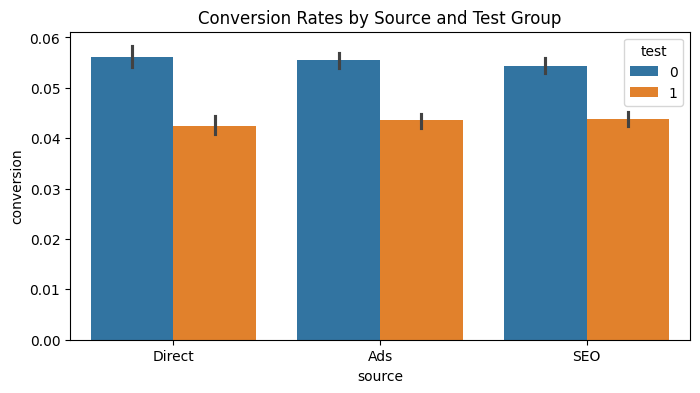

In [74]:
# 可视化不同来源的转化率
plt.figure(figsize=(8, 4))
sns.barplot(x='source', y='conversion', hue='test', data=df_clean)
plt.title('Conversion Rates by Source and Test Group')
plt.show()

图表标题为“Conversion Rates by Source and Test Group”，展示了不同来源的转化率在对照组和测试组之间的对比。

- **Direct 来源**:
  - 对照组（蓝色柱）显示了较高的转化率，约为 5.5%。
  - 测试组（橙色柱）显示了较低的转化率，约为 4.5%。
  - 这表明对于 Direct 来源的用户，新的翻译（测试组）导致了转化率的下降。
- **Ads 来源**:
  - 对照组的转化率接近 5.5%，测试组的转化率略低于 4.5%。
  - 与 Direct 来源相似，新的翻译对通过广告进入的用户也没有产生积极效果，转化率有所下降。
- **SEO 来源**:
  - 对照组的转化率约为 5.5%，而测试组的转化率低于 4.5%。
  - 与其他来源一致，SEO 来源的用户在新的翻译条件下也显示了转化率的下降。

根据这个可视化结果，我们可以得出以下结论：

1. **转化率下降**: 对于所有的来源（Direct, Ads, SEO），新的翻译（测试组）都表现出较低的转化率。无论是直接访问用户、通过广告点击进入的用户，还是通过SEO搜索来的用户，转化率在新的翻译版本中都有所下降。
2. **测试结果的显著性**: 需要结合 A/B 测试函数计算的 p 值，来进一步验证这些转化率差异是否在统计上显著。如果 p 值小于常见的显著性水平（如 0.05），则可以认为这些转化率差异不是随机的，而是由新的翻译版本引起的。
3. **测试效果负面**: 整体来看，新的翻译版本似乎对用户体验或其他方面产生了负面影响，导致用户的转化率下降。这可能表明新的翻译没有达到预期的效果，或者用户对新的翻译版本不太满意。

按照国家给出A/B test的结果：

In [75]:
# 按国家进行 A/B 测试分析
country_results = df_clean.groupby('country').apply(ab_test)

print("\n按国家分层的 A/B 测试结果:")
print(country_results)


按国家分层的 A/B 测试结果:
             control_conv_rate  treatment_conv_rate      lift  relative_lift  \
country                                                                        
Argentina             0.015071             0.013725 -0.001346      -0.089282   
Bolivia               0.049369             0.047901 -0.001468      -0.029743   
Chile                 0.048107             0.051295  0.003188       0.066266   
Colombia              0.052089             0.050571 -0.001519      -0.029152   
Costa Rica            0.052256             0.054738  0.002482       0.047497   
Ecuador               0.049154             0.048988 -0.000165      -0.003365   
El Salvador           0.053554             0.047947 -0.005607      -0.104701   
Guatemala             0.050643             0.048647 -0.001996      -0.039407   
Honduras              0.050906             0.047540 -0.003366      -0.066121   
Mexico                0.049495             0.051186  0.001692       0.034179   
Nicaragua             

C:\Users\wangjun\AppData\Local\Temp\ipykernel_12096\2705657648.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_results = df_clean.groupby('country').apply(ab_test)


在按国家分层的 A/B 测试结果中，我们分析了各个国家的测试组和对照组的转化率、提升率及其统计显著性。总体而言，大多数国家在测试组（使用新翻译版本）中的转化率低于对照组（使用旧翻译版本）的转化率，这表明新翻译版本在许多国家没有改善转化率，甚至导致了转化率的下降。

一些国家的负面影响尤为明显。例如，在阿根廷，测试组的转化率为 1.37%，低于对照组的 1.51%，转化率的下降幅度为 8.93%。虽然 p 值为 0.3218，这意味着差异在统计上不显著，但仍显示出新翻译版本的负面趋势。在萨尔瓦多，情况更加显著，测试组的转化率为 4.79%，显著低于对照组的 5.36%，相对下降幅度达到 10.47%。尽管这个结果的 p 值为 0.2483，未达到常见的统计显著性水平，但如此大的转化率差异值得进一步关注和分析。

另一方面，部分国家对新翻译版本的反应相对较好。例如，在智利，测试组的转化率为 5.13%，略高于对照组的 4.81%，显示出一个 6.63% 的相对提升。尽管这个差异的 p 值为 0.3029，不具备统计显著性，但结果仍然表明新版本在智利的表现略优于旧版本。类似地，哥斯达黎加和墨西哥也表现出轻微的积极变化，尽管它们的 p 值同样不显著。

西班牙的数据呈现出不同的情况。由于实验设计的原因，西班牙用户仅作为对照组的一部分，他们并未接触到新的翻译版本。因此，西班牙的结果仅反映了对照组的转化率，这与实验设计的初衷一致，即保持西班牙的翻译不变以作为基线。

值得注意的是，所有国家的 p 值均高于 0.05，这意味着无论是转化率的增加还是减少，差异在统计上都不显著。这表明，大多数国家中观察到的转化率变化可能是由于随机波动，而不是新翻译版本的实际效果。因此，我们建议进一步调查特定国家的用户反馈和行为数据，以更好地理解新翻译版本在某些地区表现不佳的原因。同时，也可以考虑根据每个国家的文化和语言特点对翻译版本进行优化，以提升用户体验和整体转化率。

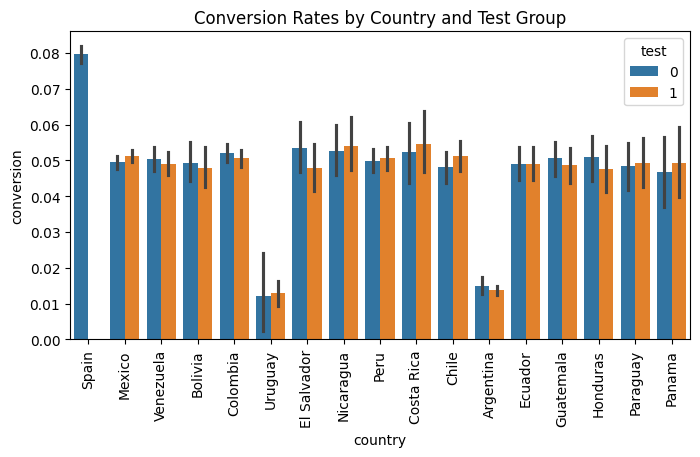

In [76]:
# 可视化一下转换率
# 可视化不同国家的转化率
plt.figure(figsize=(8, 4))
sns.barplot(x='country', y='conversion', hue='test', data=df_clean)
plt.title('Conversion Rates by Country and Test Group')
plt.xticks(rotation=90)  # 如果国家太多，可以旋转x轴标签
plt.show()

这个可视化结果展示了不同国家的转换率（conversion rate），区分了对照组（`test` = 0）和测试组（`test` = 1）。每个国家都有两根柱状条，蓝色代表对照组，橙色代表测试组。图表的标题是“Conversion Rates by Country and Test Group”，用来说明每个国家的转化率在旧翻译版本（对照组）和新翻译版本（测试组）之间的比较。

通过观察上图可以发现：

1. **西班牙（Spain）**：蓝色柱状条（对照组）的转化率最高，约为 8%。由于西班牙用户没有接触到新翻译版本，测试组的转化率未显示（橙色条为空）。这与实验设计相符，因为西班牙的翻译版本保持不变。

2. **拉丁美洲国家**：大多数拉丁美洲国家（例如墨西哥、委内瑞拉、哥伦比亚等）的对照组（蓝色条）的转化率普遍高于测试组（橙色条）。这表明新翻译版本（测试组）在这些国家的效果并不如旧版本（对照组），导致了转化率下降。
   - 几个国家，如智利（Chile）、哥斯达黎加（Costa Rica）、和尼加拉瓜（Nicaragua），测试组（橙色条）与对照组（蓝色条）的转换率非常接近，有些甚至略高，这表明新翻译版本在这些国家的表现可能稍微好于或至少与旧版本相当。

3. **转化率的变化趋势**：
   - 在多数国家中，测试组的转化率相对于对照组有不同程度的下降。特别是萨尔瓦多（El Salvador）、阿根廷（Argentina）、和洪都拉斯（Honduras），测试组的转化率显著低于对照组。
   - 只有少数国家，如智利和哥斯达黎加，显示出新版本的转换率与旧版本非常接近甚至略高的趋势，表明新翻译版本在这些国家可能更符合用户的偏好或习惯。

4. **误差线（Error Bars）**：
   - 每个柱状条上方的误差线表示每个国家的转化率的不确定性范围。误差线较长的国家，如乌拉圭（Uruguay），表明其转化率数据有更大的变动性或样本量较小。
   - 误差线较短的国家，数据更为稳定，结果更可靠。

这个可视化结果清晰地表明了不同国家在A/B测试中的表现差异。大多数国家的新翻译版本并没有带来预期的转化率提升，甚至在一些国家（如阿根廷、萨尔瓦多、洪都拉斯）显著降低了转化率。少数国家（如智利、哥斯达黎加）可能对新版本的接受度更高，但整体来看，新的翻译版本在大部分拉丁美洲国家的表现不如旧版本，建议对翻译策略进行进一步的优化和调整。

In [77]:
# 查看设备
# 按国家进行 A/B 测试分析
device_results = df_clean.groupby('device').apply(ab_test)

print("\n按设备分层的 A/B 测试结果:")
print(device_results)


按设备分层的 A/B 测试结果:
        control_conv_rate  treatment_conv_rate      lift  relative_lift  \
device                                                                    
Mobile           0.055663             0.044008 -0.011655      -0.209387   
Web              0.054750             0.042931 -0.011820      -0.215883   

             p_value  sample_size  
device                             
Mobile  4.356917e-33     201551.0  
Web     1.110435e-42     251316.0  


C:\Users\wangjun\AppData\Local\Temp\ipykernel_12096\3598476736.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  device_results = df_clean.groupby('device').apply(ab_test)


在按设备类型（移动设备和网页设备）分层的 A/B 测试结果中，我们可以看到新翻译版本在这两种设备上都导致了显著的转化率下降。对于移动设备用户，旧版本的转化率为 5.57%，而新版本的转化率降至 4.40%，这意味着转化率降低了 1.17 个百分点，相对下降幅度约为 21%。网页设备用户的情况类似，旧版本的转化率为 5.48%，而新版本的转化率降至 4.29%，转化率降低了 1.18 个百分点，相对下降幅度约为 22%。

这些下降在统计上非常显著。移动设备的 p 值为 $4.36 × 10^{-33}$，网页设备的 p 值为 $1.11 × 10^{-42}$，均远小于常见的显著性水平（0.05）。这表明，无论是移动设备还是网页设备，转化率的下降并非偶然，而是由于新翻译版本的实际影响。这种显著性也得益于较大的样本量：移动设备有超过 20 万用户参与测试，网页设备更是有超过 25 万用户。

总体来看，新翻译版本在所有设备类型上都表现不佳，显著降低了用户的转化率。这可能表明新翻译版本没有达到预期的效果，或者不符合用户的使用习惯和期望。

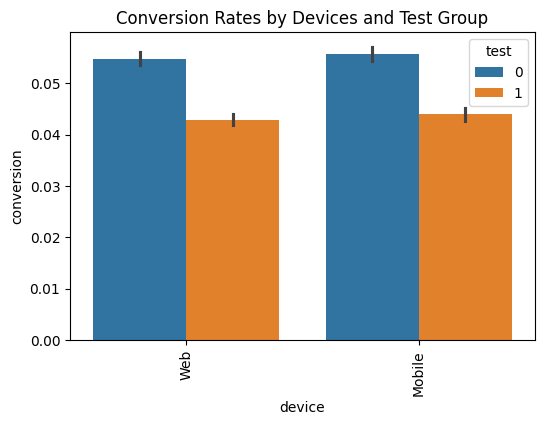

In [78]:
# 可视化一下转换率
# 可视化不同国家的转化率
plt.figure(figsize=(6, 4))
sns.barplot(x='device', y='conversion', hue='test', data=df_clean)
plt.title('Conversion Rates by Devices and Test Group')
plt.xticks(rotation=90)  # 如果国家太多，可以旋转x轴标签
plt.show()

这张图表展示了不同设备类型（网页设备和移动设备）上对照组（旧翻译版本）和测试组（新翻译版本）的转化率。结果表明，无论是在网页设备还是移动设备上，新翻译版本的转化率都显著低于旧翻译版本。在网页设备上，对照组的转化率约为 5.5%，而测试组的转化率降至约 4.3%。类似地，在移动设备上，对照组的转化率约为 5.6%，而测试组的转化率约为 4.4%。这表明，新翻译版本在两个设备类型上都未能超越旧版本，反而导致了转化率的下降。

图中的误差线较短，表明转化率数据的变异性较小，结果较为可靠。这进一步加强了结论，即新翻译版本在提升用户转化方面不如旧版本有效。这种一致性的下降表明，新的翻译版本可能在设计或内容上不符合用户的预期或需求，不论用户是通过网页设备还是移动设备访问。

In [79]:
# 按语言进行 A/B 测试分析
browser_language_results = df_clean.groupby('browser_language').apply(ab_test)

print("\n按语言分层的 A/B 测试结果:")
print(browser_language_results)


按语言分层的 A/B 测试结果:
                  control_conv_rate  treatment_conv_rate      lift  \
browser_language                                                     
EN                         0.053650             0.042616 -0.011034   
ES                         0.055431             0.043519 -0.011911   
Other                      0.054437             0.044152 -0.010286   

                  relative_lift       p_value  sample_size  
browser_language                                            
EN                    -0.205664  1.106114e-10      63079.0  
ES                    -0.214886  2.260733e-63     377160.0  
Other                 -0.188947  7.752399e-03      12628.0  


C:\Users\wangjun\AppData\Local\Temp\ipykernel_12096\790347629.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  browser_language_results = df_clean.groupby('browser_language').apply(ab_test)


按语言分层的 A/B 测试结果显示，不同语言用户在测试组（新翻译版本）和对照组（旧翻译版本）之间的转化率存在显著差异。对于设置为英语（EN）的用户，对照组的转化率为 5.37%，而测试组的转化率下降到 4.26%，转化率减少了 1.10 个百分点，约为 20.57% 的相对下降。对于西班牙语（ES）用户，对照组的转化率为 5.54%，测试组的转化率则为 4.35%，同样显示出约 1.19 个百分点的下降，或相对下降 21.49%。对于其他语言（Other）用户，对照组的转化率为 5.44%，测试组的转化率为 4.42%，转化率下降了 1.03 个百分点，相对下降 18.89%。

统计显著性方面，所有语言的 p 值均低于 0.05，尤其是西班牙语用户的 p 值极小（$2.26 × 10^{-63}$），这表明测试结果在统计上非常显著。英语用户的 p 值为 $1.11 × 10^{-10}$，其他语言用户的 p 值为 0.0078，这些都表明新翻译版本导致的转化率下降在统计上显著，而不是由随机变动引起的。

总体来看，所有语言用户的新翻译版本的表现均不如旧版本。相对下降幅度最大的语言是西班牙语用户（-21.49%），其次是英语用户（-20.57%）和其他语言用户（-18.89%）。这些结果显示，新翻译版本可能在语言适配和用户体验方面存在问题，未能提升用户的转化率。建议公司进一步分析各语言用户的反馈和行为，找出新翻译版本不如旧版本的具体原因，并对翻译版本进行优化，确保其更好地满足用户的需求。

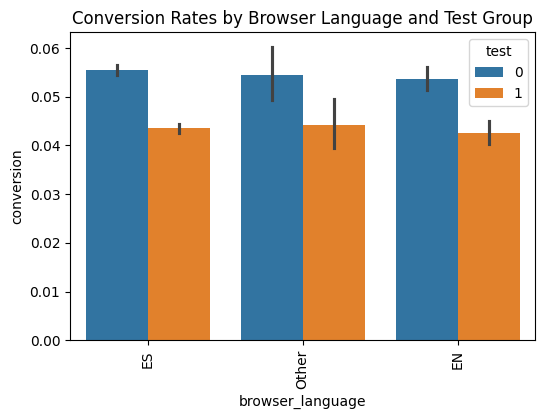

In [80]:
# 可视化一下转换率
# 可视化不同国家的转化率
plt.figure(figsize=(6, 4))
sns.barplot(x='browser_language', y='conversion', hue='test', data=df_clean)
plt.title('Conversion Rates by Browser Language and Test Group')
plt.xticks(rotation=90)  # 如果国家太多，可以旋转x轴标签
plt.show()

这张图展示了不同浏览器语言设置（西班牙语 `ES`、其他语言 `Other` 和英语 `EN`）用户的转化率，区分了对照组（旧翻译版本）和测试组（新翻译版本）。图中蓝色的柱状条代表对照组的转化率，而橙色的柱状条代表测试组的转化率。总体来看，所有语言的测试组转化率都低于对照组，这表明新翻译版本的整体表现不如旧版本。

对于西班牙语（`ES`）用户，对照组的转化率大约为 5.5%，而测试组的转化率降至大约 4.4%。这表明新翻译版本导致转化率下降了约 1.1 个百分点。这种下降同样在其他语言用户中存在：对于 `Other` 语言用户，对照组的转化率约为 5.4%，测试组的转化率下降到约 4.4%，表明转化率也下降了大约 1.0 个百分点。英语（`EN`）用户的转化率下降幅度与其他语言用户相似，测试组的转化率从对照组的约 5.4% 下降到 4.3%。

图中每个柱状条上方的误差线代表了转化率的置信区间。虽然所有语言的测试组转化率均低于对照组，但误差线表明这些差异的统计显著性。较短的误差线显示数据的变异性较小，结果较为可靠。整体来看，不同语言用户在使用新翻译版本时，转化率均有显著下降，这与之前的统计结果一致，表明新翻译版本未能提升用户转化率。

这些结果提示，新翻译版本可能在各语言的适应性或用户体验上存在问题，未能有效吸引或保持用户。建议公司进一步研究新翻译版本在不同语言用户中的表现，调查导致转化率下降的具体原因，并采取针对性的改进措施，以提升不同语言用户的满意度和转化率。

In [81]:
# 查看设备
device_results = df_clean.groupby('age').apply(ab_test)

print("\n按年龄分层的 A/B 测试结果:")
print(device_results)


按年龄分层的 A/B 测试结果:
     control_conv_rate  treatment_conv_rate      lift  relative_lift  \
age                                                                    
18            0.056539             0.043023 -0.013517      -0.239065   
19            0.056947             0.044170 -0.012777      -0.224373   
20            0.054060             0.040012 -0.014047      -0.259847   
21            0.053145             0.044563 -0.008582      -0.161489   
22            0.053870             0.044958 -0.008912      -0.165432   
23            0.056094             0.043243 -0.012851      -0.229100   
24            0.056912             0.046325 -0.010588      -0.186037   
25            0.052725             0.044147 -0.008578      -0.162692   
26            0.052181             0.044925 -0.007256      -0.139046   
27            0.054022             0.041567 -0.012455      -0.230552   
28            0.056323             0.044327 -0.011997      -0.212999   
29            0.054074             0.038741 -0

C:\Users\wangjun\AppData\Local\Temp\ipykernel_12096\2611710019.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  'relative_lift': lift / control.mean(),
C:\Users\wangjun\AppData\Local\Temp\ipykernel_12096\2611710019.py:12: RuntimeWarning: invalid value encountered in scalar divide
  'relative_lift': lift / control.mean(),
C:\Users\wangjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:6951: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
C:\Users\wangjun\AppData\Local\Temp\ipykernel_12096\1123937170.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  device_results = df_clean.groupby('a

按年龄分层的 A/B 测试结果显示了不同年龄段用户在测试组（新翻译版本）和对照组（旧翻译版本）之间的转化率差异。大多数年龄段的测试组转化率都低于对照组，这表明新翻译版本整体上没有提升转化率，甚至在许多年龄段导致了转化率的下降。

在18到30岁的年轻用户中，测试组的转化率明显低于对照组。例如，20岁的用户对照组转化率为5.41%，而测试组的转化率下降到4.00%，下降了约1.40个百分点，相对下降幅度为25.98%。这一趋势在30岁以下的用户中非常明显，所有这些年龄段的相对转化率下降幅度都在15%以上，有些甚至接近30%。这些结果表明，新翻译版本对于年轻用户的吸引力不如旧版本，可能没有满足他们的期望或需求。

随着年龄的增长，这种转化率下降的趋势在一些年龄段继续存在，但程度有所不同。例如，在40岁左右的用户中，测试组的转化率仍然较低，如41岁的用户对照组转化率为5.92%，而测试组的转化率仅为4.02%，下降了1.90个百分点，达到32.10%的相对下降幅度。然而，有些年龄段的用户，如45岁和47岁，测试组的转化率反而略高于对照组，这表明新翻译版本对这些特定年龄段的用户可能更有吸引力，或者是样本数据中的偶然现象。

对于更年长的用户（例如50岁以上），样本量显著减少，导致某些年龄段的结果显示为零或无效（如56岁以上的用户样本极少）。在这些情况下，测试结果的可靠性较低，难以得出具有统计显著性的结论。因此，针对这些年龄段的数据需要更加谨慎地解释，并可能需要更大样本量的补充测试来获得更准确的结果。

整体而言，按年龄分层的 A/B 测试结果显示了不同年龄段对新翻译版本的不同反应。大多数年轻和中年用户的转化率在新版本中显著下降，这表明新翻译版本可能不符合这些群体的需求或期望。公司可能需要根据用户的年龄特点进一步优化翻译内容，以更好地满足不同年龄段用户的偏好，从而提高转化率。

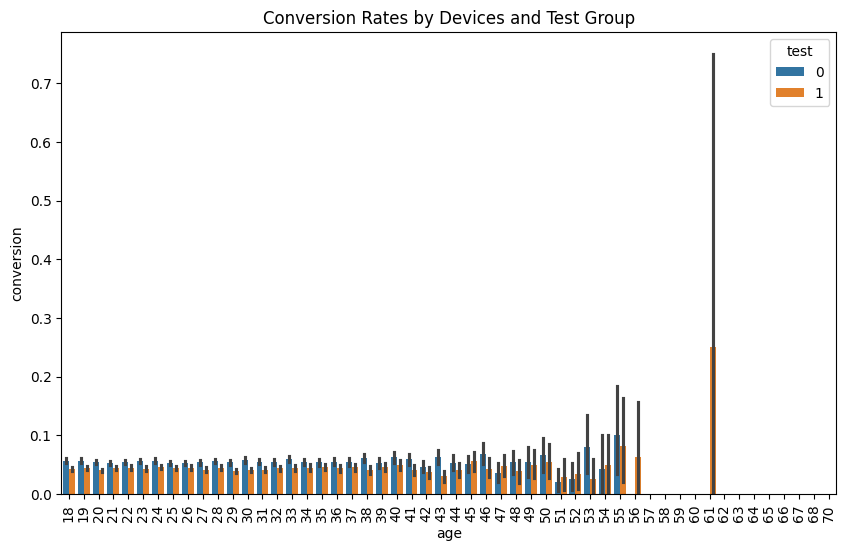

In [82]:
plt.figure(figsize=(10, 6))
sns.barplot(x='age', y='conversion', hue='test', data=df_clean)
plt.title('Conversion Rates by Devices and Test Group')
plt.xticks(rotation=90)
plt.show()

这张图展示了按年龄分层的转化率，其中对照组（旧翻译版本）和测试组（新翻译版本）的转化率分别用蓝色和橙色的柱状条表示。图表标题为“Conversion Rates by Devices and Test Group”，其中x轴表示用户的年龄，y轴表示转化率。

从图中可以看出，大多数年龄段的测试组转化率（橙色柱状条）低于对照组（蓝色柱状条），这表明新翻译版本在大多数年龄段用户中未能提高转化率。年轻用户（18到30岁）的转化率在测试组中普遍较低，这种趋势在40岁之前的用户中较为明显，显示出新翻译版本对年轻人和中年人群的吸引力可能不足。

随着年龄的增长，尤其是在50岁以上的用户群体中，转化率的差异变得更加明显和不稳定。特别是，在60岁以上的年龄段，图表中显示出极高的转化率，这可能是由于样本量较小导致的统计波动。例如，61岁用户测试组的转化率极高（橙色柱状条高于蓝色柱状条许多），显示出异常的误差线长度。这种极高的误差线和不稳定的转化率指示样本量非常少，导致数据不具代表性和可靠性。

整体来看，这张图表明新翻译版本在大多数年龄段都未能超越旧版本，并且在某些年龄段（特别是老年人群中）结果的波动性非常大，显示了样本不足的问题。这些发现表明需要针对不同年龄段进行更加细致的分析和优化，特别是针对年轻和中年用户，同时确保更老年群体的数据有足够的样本量以确保结果的可靠性。

In [83]:
# 查看一下性别
sex_results = df_clean.groupby('sex').apply(ab_test)

print("\n按语言分层的 A/B 测试结果:")
print(sex_results)


按语言分层的 A/B 测试结果:
     control_conv_rate  treatment_conv_rate      lift  relative_lift  \
sex                                                                    
F             0.054990             0.043377 -0.011613      -0.211176   
M             0.055273             0.043435 -0.011838      -0.214171   

          p_value  sample_size  
sex                             
F    3.499205e-31     188382.0  
M    1.535144e-44     264485.0  


C:\Users\wangjun\AppData\Local\Temp\ipykernel_12096\1850352338.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sex_results = df_clean.groupby('sex').apply(ab_test)


在按性别分层的 A/B 测试结果中，我们发现新翻译版本对女性和男性用户的转化率均产生了负面影响。具体而言，对于女性用户，对照组的平均转化率为 5.50%，而测试组的平均转化率下降到了 4.34%。同样地，对于男性用户，对照组的平均转化率为 5.53%，而测试组的转化率也下降到了 4.34%。这表明无论性别，新翻译版本都未能提升转化率，反而有所下降。

进一步分析显示，对于女性用户，转化率下降了 1.16 个百分点，相对下降了 21.12%；对于男性用户，转化率下降了 1.18 个百分点，相对下降了 21.42%。这些相对下降幅度表明新翻译版本对两个性别用户的转化率均产生了大约 21% 的负面影响，且这一变化在统计上具有显著性。

p值的分析结果进一步支持了这些发现。女性和男性用户的 p值分别为 $3.5 × 10^{-31}$ 和 1.5 × $10^{-44}$，远远低于 0.05 的显著性水平，表明转化率的下降并非随机波动，而是由新翻译版本导致的真实变化。此外，样本量也较为庞大，女性用户样本量为 188,382，男性用户样本量为 264,485，这增加了结果的统计可靠性。

综合来看，新翻译版本对女性和男性用户的转化率都产生了显著的负面影响，导致转化率下降约 21%。这表明新翻译版本可能存在普遍的适用性问题，对所有性别的用户体验均不佳。

In [84]:
# 查看浏览器
browser_results = df_clean.groupby('browser').apply(ab_test)

print("\n按浏览器分层的 A/B 测试结果:")
print(browser_results)


按浏览器分层的 A/B 测试结果:
             control_conv_rate  treatment_conv_rate      lift  relative_lift  \
browser                                                                        
Android_App           0.056016             0.043464 -0.012552      -0.224073   
Chrome                0.054573             0.043831 -0.010741      -0.196823   
FireFox               0.056970             0.041634 -0.015336      -0.269192   
IE                    0.054658             0.043021 -0.011637      -0.212900   
Iphone_App            0.054493             0.045826 -0.008667      -0.159053   
Opera                 0.057170             0.049948 -0.007222      -0.126320   
Safari                0.052784             0.040771 -0.012013      -0.227593   

                  p_value  sample_size  
browser                                 
Android_App  9.766424e-30     154977.0  
Chrome       2.789087e-15     101822.0  
FireFox      1.120920e-12      40721.0  
IE           2.466775e-11      61656.0  
Iphone_App   1

C:\Users\wangjun\AppData\Local\Temp\ipykernel_12096\791587341.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  browser_results = df_clean.groupby('browser').apply(ab_test)


在按浏览器分层的 A/B 测试结果中，各个浏览器的用户转化率均受到了新翻译版本的负面影响。对于使用 Android 应用的用户，对照组的平均转化率为 5.60%，而测试组的转化率下降到了 4.35%，转化率下降了 1.25 个百分点，相对下降幅度为 22.41%。类似地，对于使用 Chrome 的用户，对照组的转化率为 5.46%，而测试组的转化率下降到了 4.38%，下降了 1.07 个百分点，相对下降幅度为 19.68%。这些结果表明，使用不同浏览器的用户在新翻译版本下都经历了显著的转化率下降。

特别值得注意的是，使用 FireFox 的用户受到了最大的负面影响。对照组的转化率为 5.70%，而测试组的转化率降至 4.16%，转化率下降了 1.53 个百分点，相对下降幅度达到 26.92%。这表明 FireFox 用户对新翻译版本的响应特别不佳。其他浏览器如 IE 和 Safari 的用户也表现出了显著的转化率下降，分别下降了 1.16 个百分点（相对下降 21.29%）和 1.20 个百分点（相对下降 22.76%）。

对于 Iphone 应用和 Opera 的用户，虽然转化率也有所下降，但相对下降幅度相对较小，分别为 15.91% 和 12.63%。然而，值得注意的是，Opera 的样本量较小，仅有 6,084 人，导致其结果的统计显著性较低（p值为 0.21），这意味着 Opera 用户的转化率下降可能并不显著，更多是由于样本波动导致的。

总的来说，各浏览器用户在新翻译版本下的转化率普遍下降，且在大多数情况下这种下降在统计上显著。特别是使用 FireFox 和 Android 应用的用户，转化率下降幅度最大。这表明新翻译版本可能存在广泛的适用性问题，特别是在某些浏览器环境下表现不佳。因此，有必要进一步调查新翻译版本在不同浏览器中的表现差异，并根据具体情况进行优化和调整。

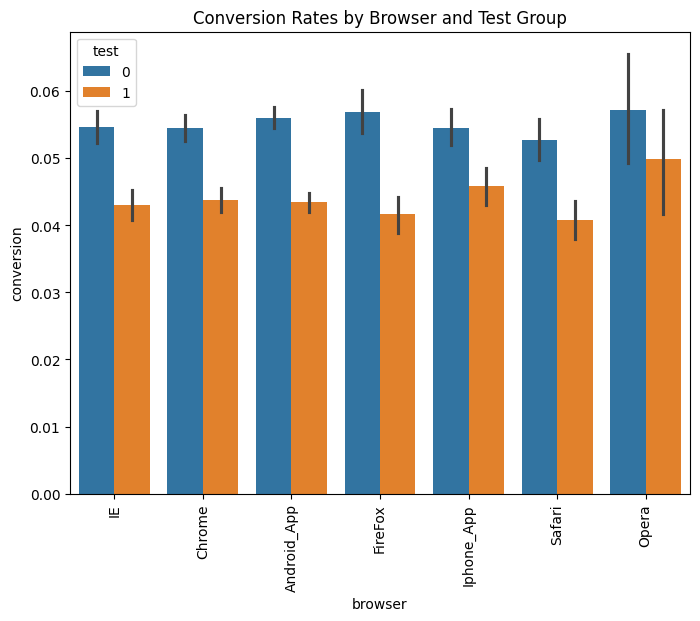

In [85]:
plt.figure(figsize=(8, 6))
sns.barplot(x='browser', y='conversion', hue='test', data=df_clean)
plt.title('Conversion Rates by Browser and Test Group')
plt.xticks(rotation=90)
plt.show()

这个柱状图展示了按浏览器分组的A/B测试转化率结果，其中蓝色柱状表示对照组（标记为“0”），橙色柱状表示测试组（标记为“1”）。图表横轴表示不同的浏览器，包括IE、Chrome、Android_App、FireFox、Iphone_App、Safari和Opera；纵轴表示转化率。

从图中可以明显看出，所有浏览器中，测试组的转化率都低于对照组。这一趋势在FireFox、Safari和Android_App中尤为明显，这些浏览器的橙色柱状显著低于蓝色柱状，表明新翻译版本对这些浏览器的用户产生了更大的负面影响。

图中还显示了转化率的误差条，这些误差条表明了转化率的置信区间。可以看到，在所有浏览器中，测试组的转化率下降不仅存在，而且这种下降在统计上具有显著性，尤其是在用户数量较多的浏览器如Chrome和Android_App中。

总的来说，该可视化图表进一步支持了之前的结论，即在不同的浏览器中，新翻译版本导致的转化率普遍下降，提示需要进一步调查和优化新翻译版本，尤其是在FireFox、Safari和Android_App这些浏览器环境中。

由于时间跨度有限，这些date数据不足以识别长期趋势、季节性变化或重大事件的影响。

# 一个自动化函数

In [86]:
import pandas as pd
from scipy import stats

def ab_test_reliability(test_table, user_table):
    # 合并两个数据表
    merged_data = pd.merge(test_table, user_table, on='user_id')
    
    # 计算整体转化率
    overall_conversion_control = merged_data[merged_data['test'] == 0]['conversion'].mean()
    overall_conversion_treatment = merged_data[merged_data['test'] == 1]['conversion'].mean()
    
    # 计算总体的统计显著性
    control_group = merged_data[merged_data['test'] == 0]['conversion']
    treatment_group = merged_data[merged_data['test'] == 1]['conversion']
    _, overall_p_value = stats.ttest_ind(control_group, treatment_group)
    
    # 判断总体转化率差异
    if overall_p_value < 0.05 and overall_conversion_treatment < overall_conversion_control:
        return False
    
    # 按用户特征（例如国家、设备类型、语言、年龄）分组分析
    user_features = ['country', 'device', 'browser_language', 'age']
    for feature in user_features:
        grouped_data = merged_data.groupby(feature)
        
        for group, data in grouped_data:
            control = data[data['test'] == 0]['conversion']
            treatment = data[data['test'] == 1]['conversion']
            
            # 如果分组数据不足，则跳过
            if len(control) < 30 or len(treatment) < 30:
                continue
            
            _, p_value = stats.ttest_ind(control, treatment)
            conversion_control = control.mean()
            conversion_treatment = treatment.mean()
            
            # 如果发现显著的转化率下降，返回 False
            if p_value < 0.05 and conversion_treatment < conversion_control:
                return False
    
    # 如果没有发现类似的问题，返回 True
    return True

1. **数据合并**:
   ```python
   merged_data = pd.merge(test_table, user_table, on='user_id')
   ```
这一步将 `test_table` 和 `user_table` 合并在一起。`test_table` 包含了用户的测试信息和转化数据，而 `user_table` 包含用户的额外信息（如年龄、国家等）。通过 `user_id` 进行合并，使得可以在一个数据表中访问所有相关信息。

2. **计算整体转化率**:
   ```python
   overall_conversion_control = merged_data[merged_data['test'] == 0]['conversion'].mean()
   overall_conversion_treatment = merged_data[merged_data['test'] == 1]['conversion'].mean()
   ```
计算对照组（`test == 0`）和测试组（`test == 1`）的整体转化率。使用 `.mean()` 方法计算每组用户的平均转化率。

4. **计算总体的统计显著性**:
   ```python
   control_group = merged_data[merged_data['test'] == 0]['conversion']
   treatment_group = merged_data[merged_data['test'] == 1]['conversion']
   _, overall_p_value = stats.ttest_ind(control_group, treatment_group)
   ```
使用 `ttest_ind` 函数对对照组和测试组进行独立样本 t 检验，计算转化率的显著性差异。`overall_p_value` 是统计检验得到的 p 值。

5. **判断整体转化率差异**:
   ```python
   if overall_p_value < 0.05 and overall_conversion_treatment < overall_conversion_control:
       return False
   ```
检查整体转化率是否存在显著差异。如果 p 值小于 0.05（表示差异在统计上显著），并且测试组的转化率低于对照组，则返回 `False`，表示测试结果不可信。

6. **按用户特征分组分析**:
   ```python
   user_features = ['country', 'device', 'browser_language', 'age']
   for feature in user_features:
       grouped_data = merged_data.groupby(feature)
   ```
定义要检查的用户特征列表，并按这些特征（如国家、设备类型、浏览器语言、年龄）对数据进行分组。

7. **按分组计算转化率和进行统计检验**:
   ```python
   for group, data in grouped_data:
       control = data[data['test'] == 0]['conversion']
       treatment = data[data['test'] == 1]['conversion']
       
       if len(control) < 30 or len(treatment) < 30:
           continue
       
       _, p_value = stats.ttest_ind(control, treatment)
       conversion_control = control.mean()
       conversion_treatment = treatment.mean()
       
       if p_value < 0.05 and conversion_treatment < conversion_control:
           return False
   ```
对每个特征分组中的数据，进一步按测试和对照组划分。检查每个分组的样本量是否足够（大于30），确保数据分析的可靠性。

使用 t 检验计算每个特征分组的转化率差异的显著性。如果在任何分组中发现测试组转化率显著低于对照组（p 值 < 0.05 且测试组转化率 < 对照组转化率），则立即返回 `False`。

8. **返回结果**:
   ```python
   return True
   ```
如果没有检测到显著的负面转化率差异（所有显著性检验的条件都未满足），则返回 `True`，表示测试结果可信。

该函数的目的是检测A/B测试中是否存在显著的转化率下降，确保结果的可信度。返回 `False` 表示检测到新版本在多个特征分组中表现不佳（显著转化率下降），建议重新评估新版本的有效性。返回 `True` 表示没有检测到显著问题，测试结果可以被信任。这个函数能够帮助自动化检测A/B测试结果的可靠性，从而更好地支持决策过程。

测试一下：

In [87]:
# 使用示例
result = ab_test_reliability(test_table, user_table)
print("测试结果是否可信：", result)

测试结果是否可信： False


`False` 的结果指的是**测试的结果下降**，而不是数据本身无法分析得到可信的结论。这意味着：

1. **测试组表现不佳**：根据你的A/B测试数据，测试组（新翻译版本）的转化率显著低于对照组（旧翻译版本）。这种显著的下降表明新版本在实际应用中效果不如旧版本。

2. **统计显著性**：函数通过统计检验（如 t 检验）来评估转化率的差异。返回 `False` 表明这种差异在统计上是显著的，意味着我们可以有很高的信心认为测试组的转化率下降不是由随机因素造成的，而是新翻译版本的实际影响。

因此，`False` 的返回结果并不表示数据质量问题或数据不足以进行分析。相反，它表明在测试中发现了显著的负面效果（即转化率下降），这使得新翻译版本的效果不如预期。换句话说，数据本身是可以信任的，但数据揭示了新版本的负面影响。